# Camilo Torres Ovalle
# Wilfredo Vega Buelvas

# TensorFlow and Keras

In [35]:
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_moons

%matplotlib inline

# Functions for plotting 2D data and decision regions

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

# 1. Multilayer neural network in TensorFlow
You need to create a neural network model in TF that is able to discriminate the two classes in the following dataset:

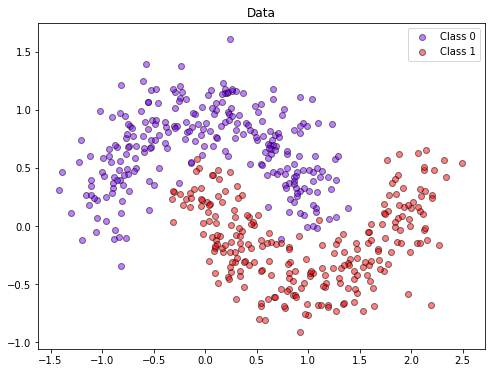

In [36]:
X, Y = make_moons(n_samples=1000, noise= 0.2, random_state=3)
x_train = X[:500]
x_test  = X[500:]
y_train = Y[:500]
y_test  = Y[500:]

pl.figure(figsize=(8, 6))
plot_data(x_train, y_train)

For this you will need to create a neural network with one hidden layer. You cannot use prebuilt models such as those in tf.estimator. Hint: extend the logistic regression example from the TensorFlow handout.

Your answer must contain the following:

A visualization of the CG of the model.
A visualization of the decision region along with the test data.
A snapshot from TensorBoard that shows the evolution of the training and test loss.

## Solución

In [41]:
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline


# Helper functions to inline visualization of computing graphs
# Extracted from: 
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Functions for plotting 2D data and decision regions

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

In [42]:
  numN = 10
graph = tf.Graph()
with graph.as_default():
    
    
    #DATOS ENTRADA:
    x = tf.placeholder(tf.float32,shape=[None,2]) 
    y_true = tf.placeholder(tf.float32,shape=None) 
    
    with tf.name_scope('hidden_layer') as scope: 
        w_1 = tf.Variable(tf.random_normal([numN,2]),dtype=tf.float32,name='weights_1')
        b1 = tf.Variable(tf.random_normal([numN,1]),dtype=tf.float32,name='bias1') 
   
        #h = tf.matmul(w_1,tf.transpose(x)) + b1
        h = tf.sigmoid(tf.matmul(w_1,tf.transpose(x)) + b1, name='sigmoid') #brosfcasting
   
    
    #MODELO INFERENCIA 
    with tf.name_scope('inference') as scope:
        w_2 = tf.Variable(tf.random_normal([1,numN]),dtype=tf.float32,name='weights')
        b = tf.Variable(0,dtype=tf.float32,name='bias') 
        y_pred = tf.sigmoid(tf.matmul(w_2,h) + b )

    #FUNCION DE PERDIDA (SIGMOIDE)
    with tf.name_scope('loss') as scope:
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
        loss = tf.reduce_mean(loss) 
  
    #FUNCION ENTRENAMIENTO
    with tf.name_scope('train') as scope:
        learning_rate = 1.0
        optimizer = tf.train.GradientDescentOptimizer(learning_rate) 
        train = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    
show_graph(graph.as_graph_def())

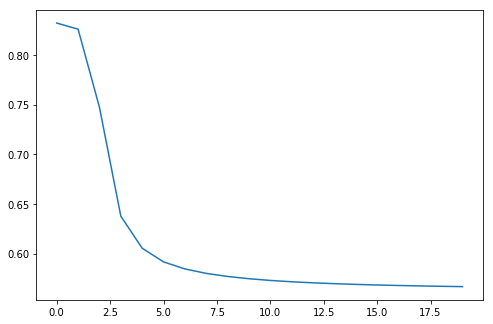

In [43]:
num_epochs = 1000
losses = []

with graph.as_default(): 
    sess = tf.Session()
    sess.run(init)      
    for step in range(num_epochs):
        sess.run(train,{x: x_train, y_true: y_train}) 
        if (step % 50 == 0):
            losses.append(sess.run(loss, {x: x_train, y_true: y_train})) 
                       
pl.figure(figsize = (8,16/3)) 
pl.plot(losses)

[[-0.7581781   0.99060273]
 [-0.27022213  1.5657994 ]
 [-1.1355128   3.8807497 ]
 [ 0.59504855 -1.346901  ]
 [ 0.3036473  -1.5556365 ]
 [-1.0712516   3.7354295 ]
 [ 1.0063585   2.381766  ]
 [-0.57728004  1.541325  ]
 [-0.01817387  2.8806489 ]
 [-1.0107664   0.7282616 ]]
[[0.00011723]]


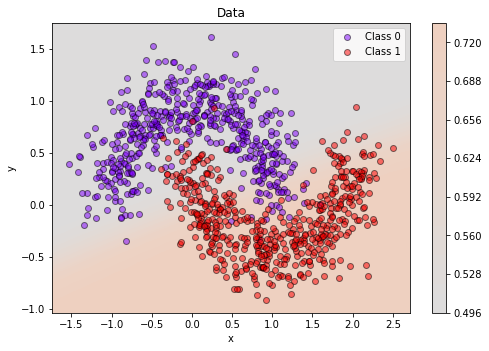

In [44]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

with graph.as_default():
    wval = sess.run(w_1)
    print(wval)
    result = sess.run(y_pred, {x:np.array([[1,2]])}) 
    print(result)
    def pred_fun(x1, x2):
        xval = np.array([[x1, x2]])
        return sigmoid(sess.run(y_pred,{x: xval}))

pl.figure(figsize = (8,16/3))    
plot_decision_region(X, pred_fun)
plot_data(X, Y)


# 2. Improving the Keras text classifier
Your goal is to improve the performance of the text classifier in the Keras handout. This is are the things that you need to try:

Different activation functions for the hidden layer (https://keras.io/activations/)
Different optimizers (https://keras.io/optimizers/)
Add dropout between the hidden layer and the output layer (https://keras.io/layers/core/#dropout)
Different initializers for the dense layers (https://keras.io/initializers/)
Try different combinations and report your findings at the end. Which configuration got the best accuracy in test?

In [45]:
# Preparando la data
import keras
import numpy as np
from keras.datasets import reuters
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer

max_words = 1000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

Using TensorFlow backend.


Loading data...
8982 train sequences
2246 test sequences
46 classes


In [46]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
num_words = max(word_index.values()) + 1
words = ['']*num_words
for word in word_index:
    words[word_index[word]] = word
print([words[i-2] for i in x_train[101][1:]])

['', 'dlr', 'and', 'cts', '', '80', 'average', 'companies', 'in', 'income', 'of', 'make', '', '', 'said', '', '', 'a', 'of', 'make', '52', '', 'said', '', 'of', '1987', '', '2', 'of', 'sold', 'general', 'states', 'to', '', 'field', 'securities', 'was', 'agricultural', '', '3', 'it', 'a', '1988', 'said', 'as', 'april', '50', 'term', 'to', 'earlier', '3', 'it', 'but', 'was', 'with', '', 'said', '', 'previously', 'be', 'sell', 'cts', 'previously', 'be', '', 'more', 'earlier', 'of', 'which', 'and', 'said', 'commerce', 'of', '1987', 'was', '', 'august', '3', 'it', 'export', 'april', 'report', 'vice', 'to', 'beef', '3', 'it', '', 'and', '000', 'for']


In [47]:
tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (8982, 1000)
x_test shape: (2246, 1000)


In [48]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (8982, 46)
y_test shape: (2246, 46)


In [49]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras import initializers

model = Sequential()

model.add(Dense(256, kernel_initializer='random_uniform',input_shape=(max_words,))) #Test accuracy: 0.789
# Different activation functions for the hidden layer
#model.add(Activation('sigmoid'))    #Test accuracy: 0.719
#model.add(Activation('softplus'))   #Test accuracy: 0.768
#model.add(Activation('relu'))       #Test accuracy: 0.778
model.add(Activation('tanh'))        #Test accuracy: 0.783
model.add(Dropout(0.7))              #Test accuracy: 0.784
#model.add(Dense(num_classes,kernel_initializer='random_uniform')) #Test accuracy: 0.768
#model.add(Dense(num_classes,kernel_initializer='random_normal'))  #Test accuracy: 0.780
model.add(Dense(num_classes,kernel_initializer='glorot_uniform'))  #Test accuracy: 0.788
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               256256    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                11822     
_________________________________________________________________
activation_2 (Activation)    (None, 46)                0         
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
_________________________________________________________________


In [50]:
from keras.optimizers import SGD
model.compile(loss='categorical_crossentropy',
              #optimizer='rmsprop',   #Test accuracy: 0.764
              #optimizer='Adadelta',  #Test accuracy: 0.764
              #optimizer='Adam',      #Test accuracy: 0.776
               optimizer=SGD(),       #Test accuracy: 0.783
              metrics=['accuracy'])  

In [52]:
model.fit(x_train, y_train, epochs=50,batch_size = 32, verbose=2)

Epoch 1/1
 - 21s - loss: 2.2759 - acc: 0.4839


In [ ]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

# Resumen de las corridas y Modelo final:

A continuación, se describen los parametros con los cuales se realizaron las simulaciones buscando la red con 
mejor accuracy

Funciones de Activación: 'sigmoid', 'softplus', 'relu', 'tanh'                                                     
Optimizadores:   'rmsprop', 'Adadelta', 'Adam', 'SGD'                                                             
Dropout: Se probó con una tasa de 0.3, 0.4, 0.5, 0.6, 0.7, 0.8                                                            
Inicializadores: 'glorot_uniform', 'random_uniform', 'random_normal'

    
    
    

# Parametros del mejor Modelo:
Con 50 Epochs                                                                                                  
                                                                                                                   
Funciones de Activación: 'tanh' en la primera capa                                                                    
Optimizadores: 'SGD'                                                                                    
Dropout: 0.7                                                                                                     
Inicializadores: 'random_uniform' en la primera capa y 'glorot_uniform' en la segunda capa

# Accuracy:

Test accuracy: 0.7849

# Código modelo:

In [ ]:
# from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras import initializers

model = Sequential()

model.add(Dense(256, kernel_initializer='random_uniform',input_shape=(max_words,)))
model.add(Activation('tanh'))      
model.add(Dropout(0.7))           
model.add(Dense(num_classes,kernel_initializer='glorot_uniform')) 
model.add(Activation('softmax'))
model.summary()

In [ ]:
from keras.optimizers import SGD
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),   
              metrics=['accuracy'])  

In [ ]:
model.fit(x_train, y_train, epochs=50,batch_size = 32, verbose=2)

In [ ]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])